# Markovitz model simulation for Wig.Games

## Python libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Dataset

In [2]:
stocks_data = glob.glob("Wig.Games\*.csv")

df = pd.DataFrame()

for stock in stocks_data:
    stock_name = stock.split("-")[0].split("\\")[1]
    data = pd.read_csv(stock, index_col="Data", parse_dates=True, header=0)
    data[stock_name] = data["Zmiana (%)"]/100
    df = pd.merge(df, data[stock_name], how="outer",
                  left_index=True, right_index=True)

In [3]:
df.tail()

,11b,cdr,cig,plw,ten
Data,,,,,
2020-03-06,-0.0293,-0.0148,0.0000,-0.0317,-0.0148
2020-03-06,-0.0293,-0.0148,-0.0409,0.0000,0.0000
2020-03-06,-0.0293,-0.0148,-0.0409,0.0000,-0.0148
2020-03-06,-0.0293,-0.0148,-0.0409,-0.0317,0.0000
2020-03-06,-0.0293,-0.0148,-0.0409,-0.0317,-0.0148


In [4]:
df.shape

(2577, 5)

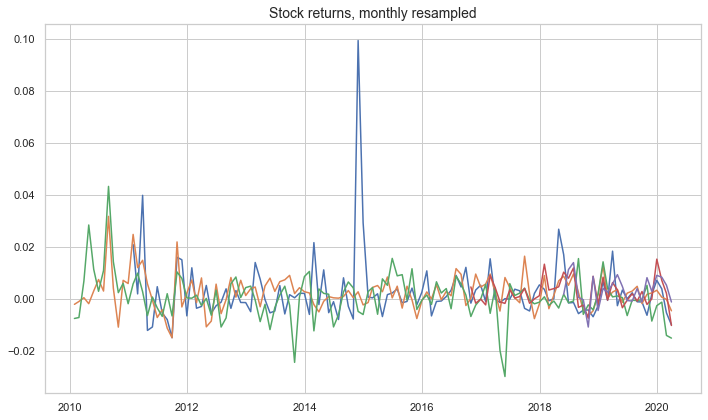

In [5]:
fig = plt.figure(figsize=(10, 6))

plt.plot(df.resample("M").mean())
#plt.legend(df.columns)
plt.title("Stock returns, monthly resampled", size=14)

plt.tight_layout()
plt.show()

## Key metrics

In [6]:
risk_free_return = 0.03
stock_return_average = df.apply("mean", axis=0)
stock_return_std = df.apply("std", axis=0)
stock_sharp_ratio = (stock_return_average.apply(
    lambda x: x - risk_free_return))/stock_return_std

In [7]:
dict = {"Average stock returns": stock_return_average,
        "Stock standard deviations": stock_return_std, "Stock Sharpes ratio": stock_sharp_ratio}
summary = pd.DataFrame(dict)
summary

,Average stock returns,Stock standard deviations,Stock Sharpes ratio
11b,0.002313,0.041564,-0.666127
cdr,0.002401,0.028079,-0.982902
cig,0.000679,0.036919,-0.794195
plw,0.002035,0.032529,-0.859695
ten,0.003386,0.035459,-0.750550


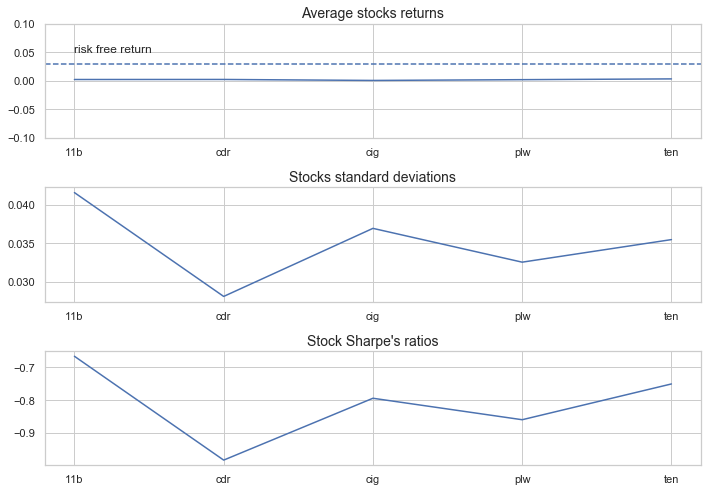

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 7))

ax[0].plot(stock_return_average)
ax[0].set_title("Average stocks returns", size=14)
ax[0].axhline(risk_free_return, linestyle="dashed")
ax[0].set_ylim(-0.1, 0.1)
ax[0].annotate("risk free return", xy=(0, risk_free_return+0.02))
ax[1].plot(stock_return_std)
ax[1].set_title("Stocks standard deviations", size=14)
ax[2].plot(stock_sharp_ratio)
ax[2].set_title("Stock Sharpe's ratios", size=14)

plt.tight_layout()
plt.show()

## Covariance matrix

In [9]:
covMatrix = pd.DataFrame.cov(df)
covMatrix.round(4).head()

,11b,cdr,cig,plw,ten
11b,0.0017,0.0002,0.0001,0.0002,0.0004
cdr,0.0002,0.0008,0.0002,0.0002,0.0003
cig,0.0001,0.0002,0.0014,0.0002,0.0004
plw,0.0002,0.0002,0.0002,0.0011,0.0006
ten,0.0004,0.0003,0.0004,0.0006,0.0013


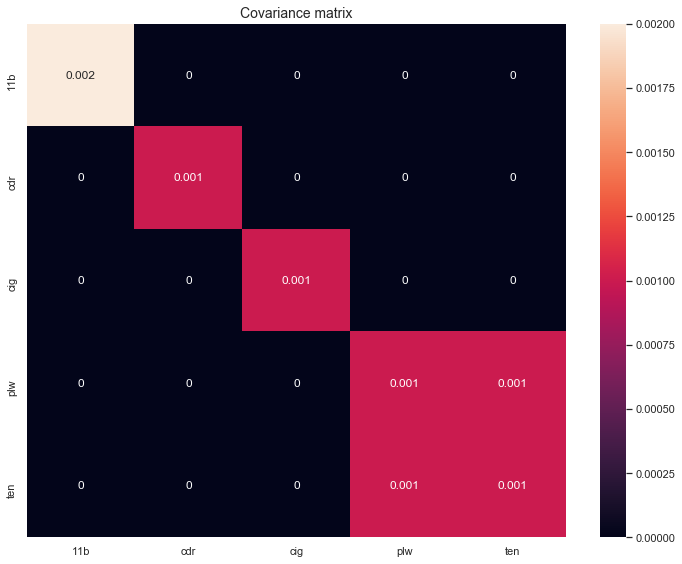

In [10]:
fig = plt.figure(figsize=(10, 8))

sns.heatmap(covMatrix.round(3), annot=True)
plt.title("Covariance matrix", size=14)

plt.tight_layout()
plt.show()

## Markovitz model

In finance, the Markowitz model - put forward by Harry Markowitz in 1952 - is a portfolio optimization model. It assists in the selection of the most efficient portfolio by analyzing various possible portfolios of the given set of securities.

The Portfolio Theory of Markowitz is based on the following assumptions: 
- Investors are rational and behave in a manner as to maximise their utility with a given level of income or money. 
- Investors have free access to fair and correct information on the returns and risk.

An efficient portfolio, also known as an 'optimal portfolio', is one that provides that best expected return on a given level of risk, or alternatively, the minimum risk for a given expected return. A portfolio is a spread of investment products, in this case, stocks.

## Portfolio simulations

In [11]:
np.random.seed(26)

sim = 100000

# creating a portfolio scenarios
# an array where simulations = rows, columns = stocks tikers, values = allocations
allocations = np.zeros((sim, len(df.columns)))

# arreys for storing the results of each portfolio scenario
returns = np.zeros(sim)
stdev = np.zeros(sim)
sharpe = np.zeros(sim)

for s in range(sim):

    # choosing a random pick size for each stock
    allocation = np.array(np.random.random(len(df.columns)))
    # each stock has its weight in the given portfolio
    allocation = allocation/np.sum(allocation)
    # assigning the favlues to the allocations array, s= row, : = following columns
    allocations[s, :] = allocation

    # calculating portfolio return
    returns[s] = np.sum(np.array(stock_return_average) * allocation * len(df))

    # calculating portfolio volitility
    stdev[s] = np.sqrt(
        np.dot(allocation.T, np.dot(covMatrix*len(df), allocation)))

    # calculating Sharpe's ratio for portfolio
    sharpe[s] = returns[s]/stdev[s]

In [12]:
print("Sharpe max:", sharpe.max().round(3), "Simulation no:", sharpe.argmax(), "Total simulations:", sim)

Sharpe max: 5.994 Simulation no: 41346 Total simulations: 100000


## Optimal portfolio

In [13]:
portfolio = pd.Series(data=list(allocations[sharpe.argmax()]), index=list(
    df.columns), name="Optimal_"+str(sharpe.argmax()))

portfolio

11b    0.137355
cdr    0.412442
cig    0.002248
plw    0.057703
ten    0.390252
Name: Optimal_41346, dtype: float64

## Markovitz efficient frontier

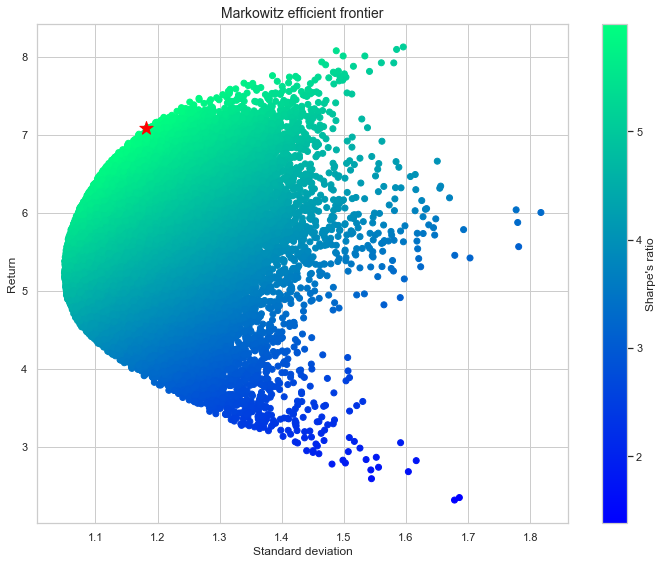

In [14]:
plt.figure(figsize=(10, 8))

plt.scatter(stdev, returns, c=sharpe, cmap="winter")
plt.colorbar(label="Sharpe's ratio")
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.title("Markowitz efficient frontier", size=14)
plt.scatter(stdev[sharpe.argmax()], returns[sharpe.argmax()],
            c='red', s=195, marker="*")

plt.tight_layout()
plt.show()